In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import time

In [7]:
# Ensure reproducibility
torch.manual_seed(41)

# Transform to Tensor
transform = transforms.ToTensor()

# Load MNIST dataset
train_data = datasets.MNIST(root='C:/Users/a/Desktop/courses/thesis/github/thesis', train=True,
                             download=True, transform=transform)
test_data = datasets.MNIST(root='C:/Users/a/Desktop/courses/thesis/github/thesis',
                            train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting C:/Users/a/Desktop/courses/thesis/github/thesis\MNIST\raw\train-images-idx3-ubyte.gz to C:/Users/a/Desktop/courses/thesis/github/thesis\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting C:/Users/a/Desktop/courses/thesis/github/thesis\MNIST\raw\train-labels-idx1-ubyte.gz to C:/Users/a/Desktop/courses/thesis/github/thesis\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting C:/Users/a/Desktop/courses/thesis/github/thesis\MNIST\raw\t10k-images-idx3-ubyte.gz to C:/Users/a/Desktop/courses/thesis/github/thesis\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting C:/Users/a/Desktop/courses/thesis/github/thesis\MNIST\raw\t10k-labels-idx1-ubyte.gz to C:/Users/a/Desktop/courses/thesis/github/thesis\MNIST\raw



First training sample:
Label: 5


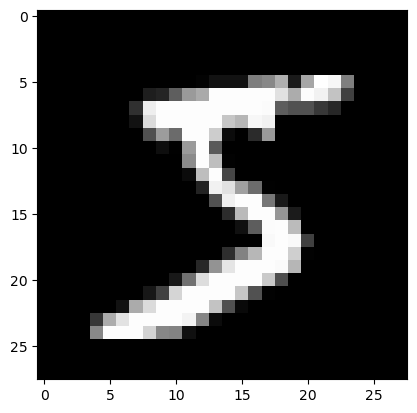

First test sample:
Label: 7


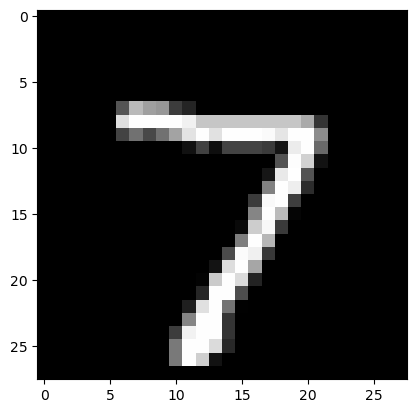

In [9]:
# Display first 5 images and labels from train dataset
print("First training sample:")
for i in range(1):
    image, label = train_data[i]  # Extract image and label
    print(f"Label: {label}")
    plt.imshow(image.squeeze(), cmap="gray")  # Display the image
    plt.show()

# Display first 5 images and labels from test dataset
print("First test sample:")
for i in range(1):
    image, label = test_data[i]  # Extract image and label
    print(f"Label: {label}")
    plt.imshow(image.squeeze(), cmap="gray")  # Display the image
    plt.show()

In [10]:
# Get one sample from train dataset
image, label = train_data[0]

# Print details about the image
print("Image Shape:", image.shape)  # Should be (1, 28, 28) since it's a grayscale image
print("Image Data Type:", type(image))  # Should be a tensor
print("Label Data Type:", type(label))  # Should be an integer

# Convert to NumPy to check pixel values
image_numpy = image.numpy()
print("Pixel Value Range:", image_numpy.min(), "to", image_numpy.max())  # Should be between 0 and 1

Image Shape: torch.Size([1, 28, 28])
Image Data Type: <class 'torch.Tensor'>
Label Data Type: <class 'int'>
Pixel Value Range: 0.0 to 1.0


In [11]:
# Define CNN model
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [12]:
# Initialize model, loss function, and optimizer
model = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training parameters
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

In [13]:
start_time = time.time()

# Training loop
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Training phase
    model.train()
    for batch, (x_train, y_train) in enumerate(train_loader, 1):
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        trn_corr += (predicted == y_train).sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 600 == 0:
            print(f'Epoch: {i+1}, Batch: {batch}, Loss: {loss.item()}')
    
    train_losses.append(loss.item())
    train_correct.append(trn_corr)
    
    # Validation phase
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            y_val = model(x_test)
            loss = criterion(y_val, y_test)
            test_loss += loss.item()
            
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum().item()
    
    test_losses.append(test_loss / len(test_loader))  # Average loss
    test_correct.append(tst_corr)

end_time = time.time()
print(f'Training Took: {(end_time - start_time) / 60:.2f} minutes')

Epoch: 1, Batch: 600, Loss: 0.1599932610988617
Epoch: 1, Batch: 1200, Loss: 0.18245436251163483
Epoch: 1, Batch: 1800, Loss: 0.46689897775650024
Epoch: 1, Batch: 2400, Loss: 0.19719699025154114
Epoch: 1, Batch: 3000, Loss: 0.008100767619907856
Epoch: 1, Batch: 3600, Loss: 0.4093847870826721
Epoch: 1, Batch: 4200, Loss: 0.007967507466673851
Epoch: 1, Batch: 4800, Loss: 0.0014044439885765314
Epoch: 1, Batch: 5400, Loss: 0.059241630136966705
Epoch: 1, Batch: 6000, Loss: 0.0004328742215875536
Epoch: 2, Batch: 600, Loss: 0.0035886536352336407
Epoch: 2, Batch: 1200, Loss: 0.2789103388786316
Epoch: 2, Batch: 1800, Loss: 0.0031850491650402546
Epoch: 2, Batch: 2400, Loss: 0.004529077094048262
Epoch: 2, Batch: 3000, Loss: 0.033750128000974655
Epoch: 2, Batch: 3600, Loss: 0.3937511444091797
Epoch: 2, Batch: 4200, Loss: 0.011714105494320393
Epoch: 2, Batch: 4800, Loss: 0.0010102804517373443
Epoch: 2, Batch: 5400, Loss: 0.00019589989096857607
Epoch: 2, Batch: 6000, Loss: 0.6479928493499756
Epoch: 3

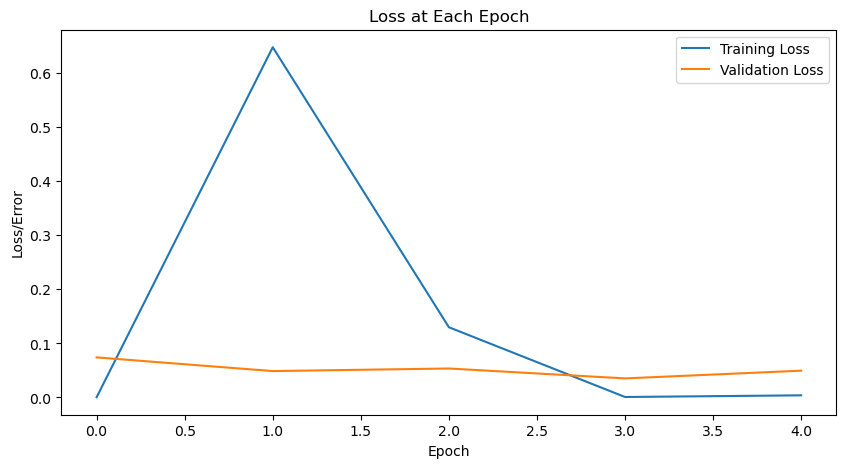

In [14]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss/Error")
plt.title("Loss at Each Epoch")
plt.legend()
plt.show()

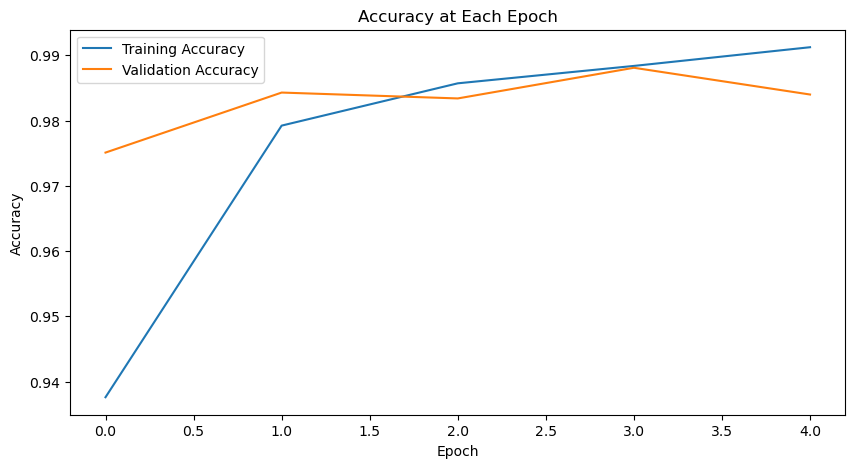

In [15]:
# Plot accuracy curves
plt.figure(figsize=(10, 5))
plt.plot([t / len(train_data) for t in train_correct], label="Training Accuracy")
plt.plot([t / len(test_data) for t in test_correct], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy at Each Epoch")
plt.legend()
plt.show()

In [16]:
# Final Model Evaluation
model.eval()
correct = 0
with torch.no_grad():
    for x_test, y_test in test_loader:
        y_val = model(x_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum().item()

total_test_samples = len(test_data)
accuracy = correct / total_test_samples
print(f'Final Test Accuracy: {accuracy:.4f}')

Final Test Accuracy: 0.9840
